In [1]:
import m2aia as m2
import numpy as np
import umap
import os
from sklearn import cluster
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sea
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import stats, signal, interpolate

from SimCLR.code.models import CLR, ContrastiveLoss


/home/jtfc/HS/M2aia/Workspace/src/m2aia/Python/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# figures
max_dim = 0
img_size = 124
target_path = "/home/jtfc/HS/M2aiaPy"
cols = 15
# clustering
n_clusters = 10
n_neighbors = 10
# training
epochs = 50
batch_size = 64

#===================================
# 1. Load image handles
#===================================
# data handling
from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639()
image_handles = []
for f in file_names[2:3]:
    I = m2.ImzMLReader(f)
    I.SetPooling(m2.m2PoolingMaximum)
    I.SetNormalization(m2.m2NormalizationTIC)
    I.SetBaselineCorrection(m2.m2BaselineCorrectionMedian, 50)
    I.Execute()
    image_handles.append(I)
    print(I.GetShape())
max_dim = np.max([np.max(I.GetShape()[:2]),max_dim])
print("MaximumDimension", max_dim)

#===================================
# 1.1 Pick peaks
#===================================
mean = I.GetMeanSpectrum()
min_indices = signal.argrelmin(mean,order=50)[0]
xs = I.GetXAxis()
peaks = find_peaks(mean, height=np.median(mean)*3.5)
centroids = xs[peaks[0]].tolist()
print("Number of centroids", len(centroids))

#===================================
# 1.2 Initialize the ion image Dataset
#===================================
trans = transforms.Compose([transforms.Lambda(lambda x : torch.Tensor(np.clip(x / np.quantile(x,0.999),0,1))),
                            transforms.CenterCrop(max_dim),
                            transforms.Resize(img_size)])
dataset = m2.IonImageDataset(image_handles, 
                            centroids=centroids, 
                            tolerance=75, 
                            tolerance_type='ppm', 
                            buffer_type='memory', 
                            transforms=trans)

#===================================
# 1.3 Initialize the augmented ion image 
# Dataset which is used during training
#===================================

# adaptions to gaussian noise to work on single channeled images
def gaussian_noise(pix, mean=0, sigmas=(0.001, 0.2)):
    sigma = np.random.uniform(sigmas[0], sigmas[1])   # randomize magnitude
    pix = pix * 255
    # adaptively tune the magnitude, hardcode according to the data distribution. every img is [0, 255]
    if pix[pix > 25].shape[0] > 0:       # 1st thre 25
        aver = torch.mean(pix[pix > 25])
    elif pix[pix > 20].shape[0] > 0:     # 2nd thre 20
        aver = torch.mean(pix[pix > 20])
    elif pix[pix > 15].shape[0] > 0:     # 3nd thre 15
        aver = torch.mean(pix[pix > 15])
    elif pix[pix > 10].shape[0] > 0:     # 4nd thre 10
        aver = torch.mean(pix[pix > 10])
    else:
        aver = torch.mean(pix)
        
    sigma_adp = sigma/153*aver           # 153, 0 homogeneous img average pixel intensity

    # scale gray img to [0, 1]
    pix = pix / 255
    # generate gaussian noise
    noise = np.random.normal(mean, sigma_adp, pix.shape)
    # generate image with gaussian noise
    pix_out = pix + torch.tensor(noise)
    pix_out = np.clip(pix_out, 0, 1)
    img_out = pix_out # convert to PIL image
    return torch.as_tensor(img_out, dtype=torch.float32)

# Dataset returns two augmentations of the same ion image Dataset entry
class AugmentedDataset(Dataset):
  def __init__(self, dataset: m2.Dataset, transform_f):
    super().__init__()
    self.dataset = dataset
    self.transform_f = transform_f

  def __len__(self):
    return self.dataset.__len__()

  def __getitem__(self, index):
    I = self.dataset[index]
    X = self.transform_f(I)
    Y = self.transform_f(I)
    return X, Y

blur_kernel_size = 9
augmentations = transforms.Compose([transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
                                    transforms.GaussianBlur(blur_kernel_size, sigma=(0.01, 0.75)), 
                                    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), 
                                    transforms.Lambda(gaussian_noise)])
aug_dataset = AugmentedDataset(dataset, augmentations)


[224 169   1]
MaximumDimension 224
Number of centroids 393


In [3]:
#===================================
# 2 Initializing the SimCLR model
#===================================
m = CLR()
m = m.cuda()
if os.path.exists("SimCLR-Pre.model"):
    state_dict = torch.load("SimCLR-Pre.model")
    m.load_state_dict(state_dict)
else:
    torch.save(m.state_dict(), "SimCLR-Pre.model")


Loaded pretrained weights for efficientnet-b0


In [4]:
#===================================
# 2.1 Predict embeddings of the images
# using the pre-finetuned model
#===================================

m.eval()
A = None
for ionImage in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    _, embedding = m(torch.tensor(ionImage[None,...]).cuda())
    embedding = embedding.cpu().detach().numpy()
    if A is None:
        A = embedding
    else:
        A = np.concatenate([A, embedding])




/tmp/ipykernel_161238/1770824184.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, embedding = m(torch.tensor(ionImage[None,...]).cuda())


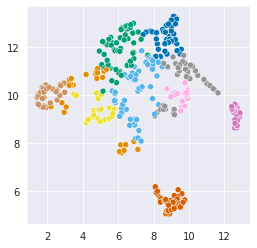

In [5]:
#===================================
# 2.2 Cluster the results using SpectralCustering
#===================================
predictor =  cluster.SpectralClustering(random_state=42,
                                   n_clusters=n_clusters, 
                                   n_neighbors = n_neighbors,
                                   affinity = 'nearest_neighbors', 
                                   assign_labels='discretize')
clusteredA = predictor.fit_predict(A)

#===================================
# 2.3 Use UMAP embeddings
#===================================
transformer = umap.UMAP(random_state=65)
transformedA = transformer.fit_transform(A)

sea.set_style('darkgrid')
plt.figure(figsize=(4,4))
fig = sea.scatterplot(x=transformedA[:,0], y=transformedA[:,1],hue=clusteredA, legend=False, palette="colorblind")


plt.savefig(f"{target_path}/FigS81_pre.eps", dpi=350)
plt.savefig(f"{target_path}/FigS81_pre.tif", dpi=350)
plt.savefig(f"{target_path}/FigS81_pre.png", dpi=350)

In [6]:
#===================================
# 3 Load trained model parameters
#===================================
if os.path.exists("SimCLR.model"):
    state_dict = torch.load("SimCLR.model")
    m.load_state_dict(state_dict)
else:
#===================================
# 3 Start finetuning and save model
#===================================

    loss = ContrastiveLoss(batch_size)
    loss = loss.cuda()

    optim = Adam(m.parameters())
    scheduler = CosineAnnealingLR(optim, epochs)

    dataloader = DataLoader(aug_dataset,
                            batch_size = batch_size, 
                            sampler = SubsetRandomSampler(list(range(len(aug_dataset)))),
                            pin_memory = True,
                            drop_last = True)

    m.train()
    ## main fit steps
    total_losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for i, [X, Y] in enumerate(dataloader):
            X = X.cuda(non_blocking=True)
            Y = Y.cuda(non_blocking=True)
            _, proj_X = m(X)
            _, proj_Y = m(Y)
            loss_value = loss(proj_X, proj_Y)
            epoch_losses.append(loss_value)
            
            # backward
            optim.zero_grad()
            loss_value.backward()
            optim.step()

        # update lr
        scheduler.step()
        losses_np = torch.tensor(epoch_losses).cpu().numpy()
        print('epoch {} loss: {}'.format(epoch, np.mean(losses_np)))
    
    torch.save(m.state_dict(), "SimCLR.model")

In [12]:
#===================================
# 3.1 Predict embeddings of the images
# using the finetuned model
#===================================

m.eval()
hatA = None
for ionImage in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    _, embedding = m(torch.tensor(ionImage[None,...]).cuda())
    embedding = embedding.cpu().detach().numpy()
    if hatA is None:
        hatA = embedding
    else:
        hatA = np.concatenate([hatA, embedding])

/tmp/ipykernel_161238/186080792.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, embedding = m(torch.tensor(ionImage[None,...]).cuda())


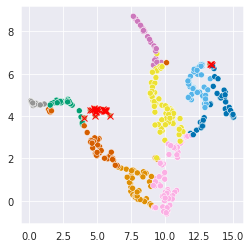

In [21]:
#===================================
# 3.2 Cluster the results using SpectralCustering
#===================================
predictor = cluster.SpectralClustering(random_state=42,
                                n_clusters=n_clusters, 
                                n_neighbors = n_neighbors,
                                affinity = 'nearest_neighbors', 
                                assign_labels='discretize')
clusteredHatA = predictor.fit_predict(hatA)

#===================================
# 3.3 Use UMAP embeddings
#===================================
transformer = umap.UMAP(random_state=65)
transformedHatA = transformer.fit_transform(hatA)

targetCluster = 5

sea.set_style('darkgrid')
plt.figure(figsize=(4,4))
import pandas as pd
# data = pd.DataFrame(np.concatenate([r, c[...,None]],axis=1))

fig = sea.scatterplot(x=transformedHatA[:,0], y=transformedHatA[:,1], hue=clusteredHatA ,legend=False, palette='colorblind')
plt.plot(transformedHatA[:,0][clusteredHatA == targetCluster], transformedHatA[:,1][clusteredHatA == targetCluster], 'rx')


# plt.title("B", {'fontweight' : 'bold',
#  'verticalalignment': 'baseline',
#  'horizontalalignment': 'left'})
plt.savefig(f"{target_path}/FigS83_post.eps", dpi=350)
plt.savefig(f"{target_path}/FigS83_post.tif", dpi=350)
plt.savefig(f"{target_path}/FigS83_post.png", dpi=350)

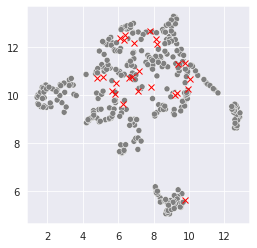

In [22]:
#===================================
# 2.3 Use UMAP embeddings
#===================================
# r_0 = t.transform(dt_0)
# c_0 = km_0.fit_predict(r_0)

sea.set_style('darkgrid')
plt.figure(figsize=(4,4))
d = sea.color_palette("light:grey", as_cmap=True)
markedClusters = clusteredHatA
markedClusters[markedClusters!=targetCluster] = 250
fig = sea.scatterplot(x=transformedA[:,0], y=transformedA[:,1], hue=markedClusters, legend=False, palette=d)
plt.plot(transformedA[:,0][clusteredHatA == targetCluster], transformedA[:,1][clusteredHatA == targetCluster], 'rx')
# plt.plot(r_0[:,0][c == 2], r_0[:,1][c == 2], 'or')
# plt.title("A", {'fontweight' : 'bold',
#  'verticalalignment': 'baseline',
#  'horizontalalignment': 'left'})
plt.savefig(f"{target_path}/FigS81_pre.eps", dpi=350)
plt.savefig(f"{target_path}/FigS81_pre.tif", dpi=350)
plt.savefig(f"{target_path}/FigS81_pre.png", dpi=350)

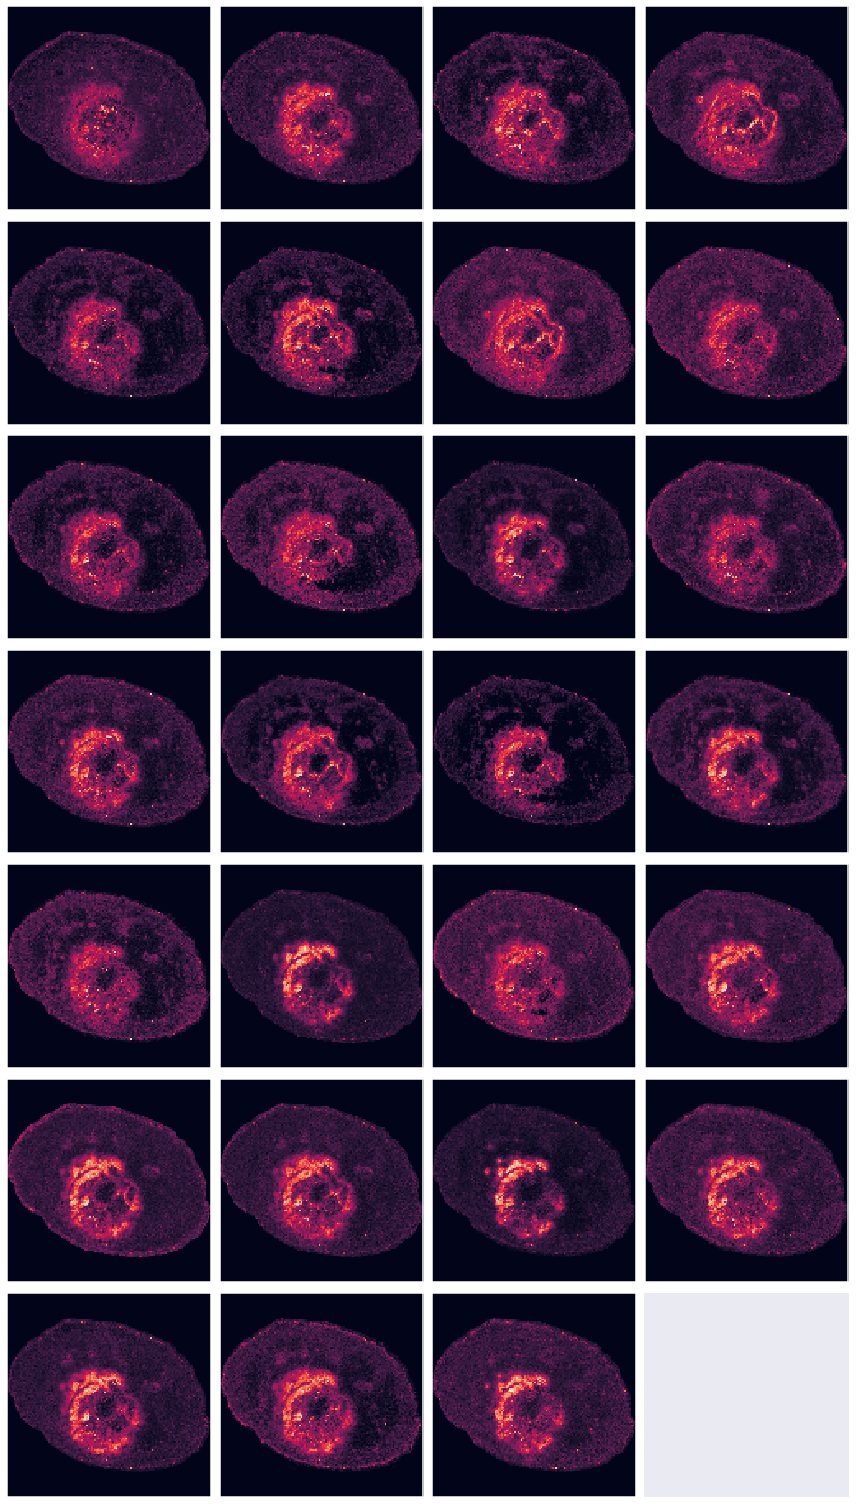

In [23]:
import seaborn_image as isns
ids = np.argwhere(c == target_c).flatten().tolist()
images=[]
for id in ids:
    images.append(dataset[id][0])

isns.ImageGrid(images, cbar=False, col_wrap=4)
plt.savefig(f"{target_path}/FigS8Cluster.png", dpi=350)

In [24]:
#===================================
# 4 Visualize images of all clusters
#===================================

rows_c0 = 0
int_c0 = []
for ci in np.unique(c_0):
    ids = np.argwhere(c_0 == ci).flatten().tolist()
    rows_c0 += (len(ids)-1)//cols + 1
    ii = None
    for id in ids:
        if ii is None:
            ii = dataset[id]
        else:
            ii += dataset[id]
    int_c0.append(torch.sum(ii)/len(ids))

rows_c = 0
int_c = []
for ci in np.unique(c):
    ids = np.argwhere(c == ci).flatten().tolist()
    rows_c += (len(ids)-1)//cols + 1
    ii = None
    for id in ids:
        if ii is None:
            ii = dataset[id]
        else:
            ii += dataset[id]
    int_c.append(torch.sum(ii)/len(ids))

rows = max(rows_c0, rows_c)

img = np.zeros([rows*img_size, (2*cols+1)*img_size])
current_row = 0

for ci in np.unique(c_0)[np.argsort(int_c0)]:
    ids = np.argwhere(c_0 == ci)
    sea.set_style('white')

    cluster_rows = (len(ids)-1)//cols + 1
    for i in range(cluster_rows):
        for j in range(cols):
            try:
                img[(current_row+i)*img_size:(current_row +(i+1))*img_size, j*img_size:(j+1)*img_size] = dataset[ids[i*cols+j][0]][0]
            except:
                break
    img[(current_row)*img_size,:cols*img_size] = 1
    current_row += cluster_rows


current_row = 0
for ci in np.unique(c)[np.argsort(int_c)]:
    ids = np.argwhere(c == ci)
    sea.set_style('white')

    cluster_rows = (len(ids)-1)//cols + 1
    for i in range(cluster_rows):
        for j in range(cols):
            try:
                img[(current_row+i)*img_size:(current_row +(i+1))*img_size, (cols+1)*img_size + j*img_size:(cols+1)*img_size +(j+1)*img_size] = dataset[ids[i*cols+j][0]][0]
            except:
                break
    img[(current_row)*img_size,(cols+1)*img_size:] = 1
    current_row += cluster_rows

img -= np.mean(img)
img /= np.std(img)
fig = plt.figure()
plt.imshow(img,cmap='cividis')
plt.axis('off')

plt.savefig(f"{target_path}/FigS84.eps", dpi=350)
plt.savefig(f"{target_path}/FigS84.tif",  dpi=350)
plt.savefig(f"{target_path}/FigS84.png",  dpi=350)

NameError: name 'c_0' is not defined